## From Raw SASE → 220-DBM → 40 eV Spectral Filter


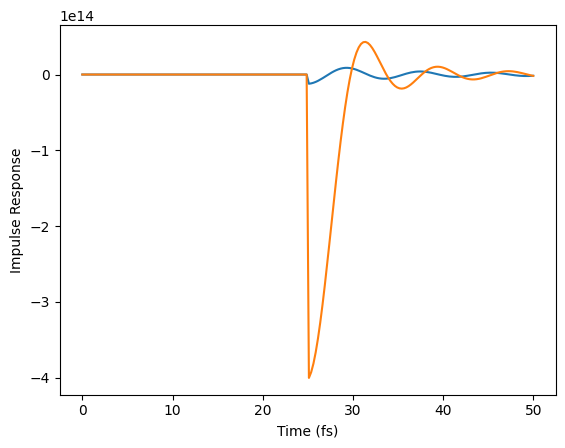

In [1]:
from SASE_mono import *
from Constants import *
import matplotlib.pyplot as plt
import numpy as np

t = np.linspace(0, 50e-15, 200)
E0 = 8e3 * e

impulse_response = Roh(t, E0)

plt.plot(t*1e15, np.real(impulse_response),label="Re")
plt.plot(t*1e15, np.imag(impulse_response),label="Im")
plt.xlabel('Time (fs)')
plt.ylabel('Impulse Response')
plt.show()

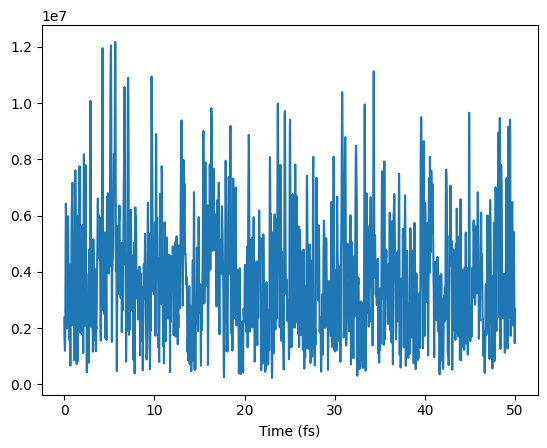

In [ ]:
def generate_sase_field_t(t, E0, deltaE):
    """
    Generate a SASE-like time-domain field by Fourier transforming a Gaussian spectrum with random phases.

    Parameters
    ----------
    t       : pulse time grid (1D array of time points)
    deltaE  : photon energy bandwidth (FWHM of spectrum)
    E0      : central photon energy [J]

    Returns
    -------
    field_t : 1D complex time-domain field
    """
    f0 = E0 / h  # central frequency
    deltaf = deltaE / h  # FWHM bandwidth in frequency

    freqs = np.linspace(f0 - 5 * deltaf, f0 + 5 * deltaf, len(t))  # frequency grid
    phases = np.random.uniform(-np.pi, np.pi, len(freqs))

    #print(len(freqs))

    spectrum = np.exp(-0.5 * (freqs - f0)**2 / (deltaf**2)) * np.exp(1j * phases) # Gaussian spectrum

    #plt.plot(freqs, np.abs(spectrum), label='Spectrum Magnitude')
    #plt.plot(freqs, np.angle(spectrum), label='Spectrum Phase')

    field_t = np.fft.ifft(spectrum)  
    dt = t[1]-t[0]
    field_t /= np.sqrt(np.sum(np.abs(field_t)**2)*dt)   

    return field_t

t = np.linspace(0, 50e-15, 2000)  # time grid
E0 = 8e3 * e
deltaE = 1e-4 * E0

field_t = generate_sase_field_t(t, E0, deltaE)

#plt.plot(t * 1e15, np.real(field_t), label="Re")
#plt.plot(t * 1e15, np.imag(field_t), label="Im")
plt.plot(t * 1e15, np.abs(field_t), label="Abs")
plt.xlabel('Time (fs)')
plt.show()
